# Comparing collections (Part One)

* Set comparison
* Ordered collections
* Ranked collections
* Collection transformation

In [22]:
import random
import collections
import operator
import time

import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import twitter
%matplotlib inline

import count_min

# some matplotlib color-mapping 
cmap = plt.get_cmap('viridis')
c_space = np.linspace(0,99,100)

# Set comparison

In [4]:
# create two sets of data scientists
a = set(['josh','fiona','scotty','skippy'])
b = set(['jeff','whitney','fiona'])

In [5]:
a.intersection(b)

/Users/jkolb/pyenvs/3.5.1/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/jkolb/pyenvs/3.5.1/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


{'fiona'}

In [6]:
c = set(range(10))
d = set(range(8,15))

In [7]:
c.intersection(d)

{8, 9}

In [8]:
c.union(d)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

# List comparison

## Number sequences

In [9]:
# create an ordered sequence of evenly-spaced integers
# create a second ordered seqence of intergers, which differs from the first by only noise
a = np.array([[i,i+np.random.normal()] for i in range(100)])

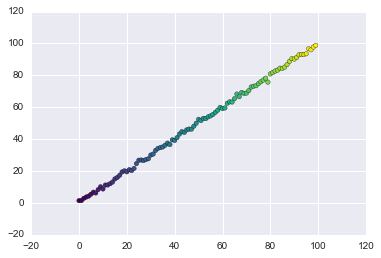

In [10]:
# the color variation shows the sequence order
plt.scatter(a[:,0],a[:,1],c=c_space,cmap=cmap)

In [11]:
# check the the correlation between the sequences (off-diagonal elements), 
# which will be high for small noise
np.corrcoef(a,rowvar=0)

array([[ 1.        ,  0.99951139],
       [ 0.99951139,  1.        ]])

In [12]:
# now create two-similarly related sequences, but with non-even spacing and larger noise
_ = [1,4,5,8,15,45,48,50,55,60,88,89,90,93,99]
b = np.array([[i,i+np.random.normal()*5] for i in _])

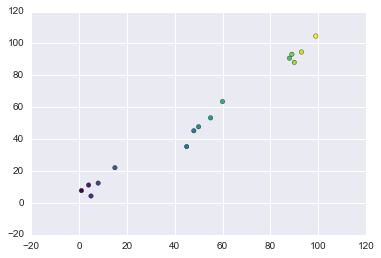

In [13]:
plt.scatter(b[:,0],b[:,1],c=np.linspace(0,99,len(b)),cmap=cmap)

In [14]:
# check the correlation
np.corrcoef(b,rowvar=0)

array([[ 1.        ,  0.99154274],
       [ 0.99154274,  1.        ]])

In [15]:
# now create randomly-ordered seqences with larger noise


_ = np.array([random.random()*100 for _ in range(100)])
c = np.array([[i,i+np.random.normal()*10] for i in _])

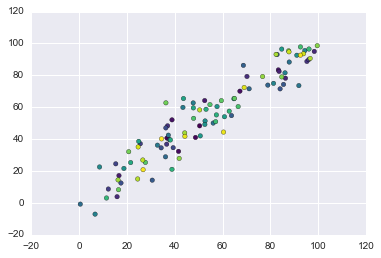

In [16]:
plt.scatter(c[:,0],c[:,1],c=c_space,cmap=cmap)

In [17]:
# the correlation coefficient is still relatively large
np.corrcoef(c,rowvar=0)

array([[ 1.        ,  0.94772484],
       [ 0.94772484,  1.        ]])

Try relating with the nosie scale and sparsity of the sequences with the correlation coefficient.


# Ordinal comparison

e.g. comparing rank

In [50]:
"""
Get Tweets from the Twitter public API
"""
import yaml

# Get your Twitter API tokens
# this is specific to my computer; modify for yours
my_creds_file = '/Users/jkolb/.twitter_api_creds'
creds = yaml.load(open(my_creds_file))
consumer_key = creds['audience']['consumer_key']
consumer_secret = creds['audience']['consumer_secret']
access_token_key = creds['audience']['token']
access_token_secret = creds['audience']['token_secret']

In [ ]:
api = twitter.Api(consumer_key=consumer_key,
                 consumer_secret=consumer_secret,
                 access_token_key=access_token_key,
                 access_token_secret=access_token_secret
                 )

mom_tweets = []
for _ in range(20):
    mom_tweets.extend( api.GetSearch("mom",count=100) )
    time.sleep(1)

In [ ]:
"""
Get Tweets from the Gnip Search API
"""

"""
from search.api import Query
import json
import yaml
creds = yaml.load(open('/Users/jkolb/.creds.yaml'))

# set up a query to the Gnip Search API
q = Query(creds['username'],
          creds['password'],
          creds['search_endpoint'],
          paged=True,
          hard_max = 1000,
          search_v2 = True
          )

# query parameters
start_date = '2016-08-01T00:00'
end_date = '2016-09-01T00:00'
rule = 'mom'

# get the tweet data
q.execute(rule,start=start_date,end=end_date)
mom_tweets = list(q.get_activity_set())
""""""

In [44]:
def token_frequency(tweets,num_top_terms = 30,delta=10**-5,epsilon=0.001,):
    """
    Space-tokenize tweet bodies and 
    return exact and approximate 1-gram counts
    
    Approximate the counts with a count-min sketch
    """
    
    terms = collections.defaultdict(int)
    sketch = count_min.Sketch(dict(delta=delta,epsilon=epsilon,k=num_top_terms))
    for tweet in tweets:
        try:
            tokens = tweet['body'].split()
        except TypeError:
            tokens = tweet.AsDict()['text'].split()
        for token in tokens:
            terms[token.lower()] += 1
            sketch.update(token.lower(),1)
    return (terms,sketch)

In [45]:
def display_two_lists(list_1,list_2):
    """helper function"""
    for x,y in zip(list_1,list_2):
        print(x,y)

In [46]:
num_top_terms = 30
# accuracy parameters for CM sketch
delta = 10**-4
epsilon = 0.01

In [47]:
# get exact and approximate top terms and counts
mom_terms,mom_sketch = token_frequency(mom_tweets,num_top_terms,delta,epsilon)
exact_top_mom_terms = list(reversed(sorted(mom_terms.items(),key = operator.itemgetter(1))))[:num_top_terms]
approx_top_mom_terms = [(term,count) for count,term in reversed(sorted(mom_sketch.top_k.values(),key = operator.itemgetter(0)))]

**Kendall's tau coefficient** is a sort of correlation coefficient that is proportional to the difference between the number of _concordant_ pairs and the number of _discordant_ pairs.  

In [48]:
kt_result = scipy.stats.kendalltau(exact_top_mom_terms,approx_top_mom_terms)
kt_result.correlation

/Users/jkolb/pyenvs/3.5.1/lib/python3.5/site-packages/scipy/stats/stats.py:250: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


0.78551229330666639

In [49]:
display_two_lists(exact_top_mom_terms,approx_top_mom_terms)

('mom', 1507) ('mom', 1512)
('rt', 1236) ('rt', 1248)
('my', 941) ('my', 946)
('to', 901) ('to', 911)
('and', 745) ('and', 783)
('your', 710) ('your', 720)
('i', 648) ('i', 648)
('you', 551) ('you', 551)
('a', 431) ('mom:', 453)
('mom:', 424) ('a', 431)
('me', 415) ('the', 425)
('the', 413) ('me', 419)
('this', 283) ('is', 299)
('is', 279) ('this', 286)
('me:', 231) ('me:', 247)
('when', 229) ('when', 236)
('how', 219) ('her', 219)
('her', 205) ('how', 219)
('for', 201) ('for', 201)
('of', 185) ('of', 185)
('she', 175) ('she', 183)
('it', 160) ('been', 178)
('been', 157) ('through', 177)
(':', 156) ('@pearcegodeep:', 172)
('many', 156) ('"', 167)
('"', 156) ('it', 164)
('through', 150) ('https://t.co/esugkx28mv', 164)
('@pearcegodeep:', 142) (':', 160)
('https://t.co/esugkx28mv', 142) ('many', 156)
('do', 132) ('do', 154)


A harder problem: how to account for the varying importance of rank?

# Over/under-indexing

In [51]:
# get some data around the term 'dad'

# public API version
dad_tweets = []
for _ in range(20):
    dad_tweets.extend( api.GetSearch("dad",count=100) )
    time.sleep(1)

In [53]:
"""
# Gnip API verions
rule = 'dad'
q.execute(rule,start=start_date,end=end_date)
dad_tweets = list(q.get_activity_set())
"""

"\n# Gnip API verions\nrule = 'dad'\nq.execute(rule,start=start_date,end=end_date)\ndad_tweets = list(q.get_activity_set())\n"

In [54]:
dad_terms,dad_sketch = token_frequency(dad_tweets,num_top_terms,delta,epsilon)
exact_top_dad_terms = list(reversed(sorted(dad_terms.items(),key = operator.itemgetter(1))))[:num_top_terms]
approx_top_dad_terms = [(term,count) for count,term in reversed(sorted(dad_sketch.top_k.values(),key = operator.itemgetter(0)))]

In [55]:
display_two_lists(exact_top_dad_terms,exact_top_mom_terms)

('dad', 1549) ('mom', 1507)
('rt', 1127) ('rt', 1236)
('to', 980) ('my', 941)
('i', 860) ('to', 901)
('the', 844) ('and', 745)
('me', 714) ('your', 710)
('you', 690) ('i', 648)
('your', 675) ('you', 551)
('on', 675) ('a', 431)
('he', 655) ('mom:', 424)
('my', 655) ('me', 415)
('before', 538) ('the', 413)
('please', 526) ('this', 283)
('yo!', 510) ('is', 279)
('planet.', 510) ('me:', 231)
('@donaldjtrumpjr!', 510) ('when', 229)
('destroys', 510) ('how', 219)
('ask', 510) ('her', 205)
('twitter.', 510) ('for', 201)
('follow', 510) ('of', 185)
('resign', 510) ('she', 175)
('noticed', 510) ('it', 160)
('thanks…', 490) ('been', 157)
('@sethrogen:', 490) (':', 156)
('and', 376) ('many', 156)
('is', 346) ('"', 156)
('a', 339) ('through', 150)
('for', 231) ('@pearcegodeep:', 142)
('are', 193) ('https://t.co/esugkx28mv', 142)
('this', 182) ('do', 132)


But we don't really care about rank here. We care about removing the effect of a baseline.

In [56]:
def normalize_by_difference(term_counts,baseline_counts):
    """define a normalized term frequency that subtracts off a baseline count"""
    normed_term_counts = {}
    for term,count in term_counts.items():
        try:
            normed_term_counts[term] = count - baseline_counts[term]
        except KeyError:
            normed_term_counts[term] = count
    return normed_term_counts

In [57]:
normalized_results = normalize_by_difference(dad_terms,mom_terms)

# look at top of list to see most "dad"-like terms
list(reversed(sorted(normalized_results.items(), key = operator.itemgetter(1))))[:20]

[('dad', 1462),
 ('on', 590),
 ('he', 563),
 ('before', 538),
 ('yo!', 510),
 ('planet.', 510),
 ('resign', 510),
 ('@donaldjtrumpjr!', 510),
 ('destroys', 510),
 ('twitter.', 510),
 ('noticed', 510),
 ('ask', 494),
 ('please', 492),
 ('thanks…', 490),
 ('@sethrogen:', 490),
 ('follow', 484),
 ('the', 431),
 ('me', 299),
 ('i', 212),
 ('you', 139)]

In [58]:
# and look at the bottom of the list to see the mom-like terms
list(reversed(sorted(normalized_results.items(), key = operator.itemgetter(1))))[-20:]

[('go', -77),
 ('at', -77),
 ('did', -86),
 ('a', -92),
 ('been', -95),
 ('times', -97),
 ('do', -99),
 ('this', -101),
 ('an', -102),
 ('someone', -105),
 ('rt', -109),
 ('her', -114),
 ('many', -153),
 ('"', -155),
 ('when', -160),
 ('how', -191),
 ('me:', -227),
 ('my', -286),
 ('and', -369),
 ('mom', -1412)]

But this normalization-by-difference only works if the two term frequency distributions have the same scale of counts. 

In [59]:
def normalize_by_fraction(term_counts,baseline_counts):
    """normalize counts by the difference of the term-fractions for each distribution"""
    normed_term_counts = {}
    B = sum(baseline_counts.values())
    A = sum(term_counts.values())
    for term,count in term_counts.items():
        try:
            # fraction of baseline distribution for this term
            b_frac = baseline_counts[term]/B
        except KeyError:
            b_frac = 0
        
        # fraction of primary term frequency distribution for this term
        a_frac = count/A
        
        factor = (a_frac-b_frac)
        normed_term_counts[term] = count * factor 
    return normed_term_counts

In [60]:
normalized_results = normalize_by_fraction(dad_terms,mom_terms)
sorted_list = list(reversed(sorted(normalized_results.items(), key = operator.itemgetter(1))))
sorted_list[:20]

[('dad', 65.04625878816911),
 ('on', 11.35391535337112),
 ('he', 10.49533948411985),
 ('the', 9.62448294280985),
 ('before', 8.356979933593186),
 ('yo!', 7.50974447812906),
 ('planet.', 7.50974447812906),
 ('resign', 7.50974447812906),
 ('@donaldjtrumpjr!', 7.50974447812906),
 ('destroys', 7.50974447812906),
 ('twitter.', 7.50974447812906),
 ('noticed', 7.50974447812906),
 ('please', 7.42691656924851),
 ('ask', 7.25358374982895),
 ('follow', 7.0934832946413815),
 ('thanks…', 6.932293922332899),
 ('@sethrogen:', 6.932293922332899),
 ('me', 5.417262730735218),
 ('i', 3.85985063825802),
 ('you', 1.8111924301860725)]

Well, this sort of works. We could also comine the term-fractions in other ways, e.g. a ratio (a_frac/b_frac), or the relative difference ( [a_frac-b_frac]/a_frac ). 

In the end, we need to think harder about what differences and similarities we want to be able to highlight and ignore. See Part Two...